In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import scipy.optimize as opt

In [4]:
tables = ['probka.csv', 'Al.csv', 'Pb.csv', 'Fe.csv']
names = ['Пробка', 'Алюминий', 'Свинец', 'Железо']

layer_length_table = pd.read_csv("material_len.csv")
layer_length = {key: val for key, val in zip(names, layer_length_table['len'])}

In [58]:
def interp_func(x, bias, amplitude, base):
    return bias + amplitude * np.exp(x * base)

### Приближение экспериментальных данных экспонентой

/home/vladimir/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vladimir/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vladimir/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


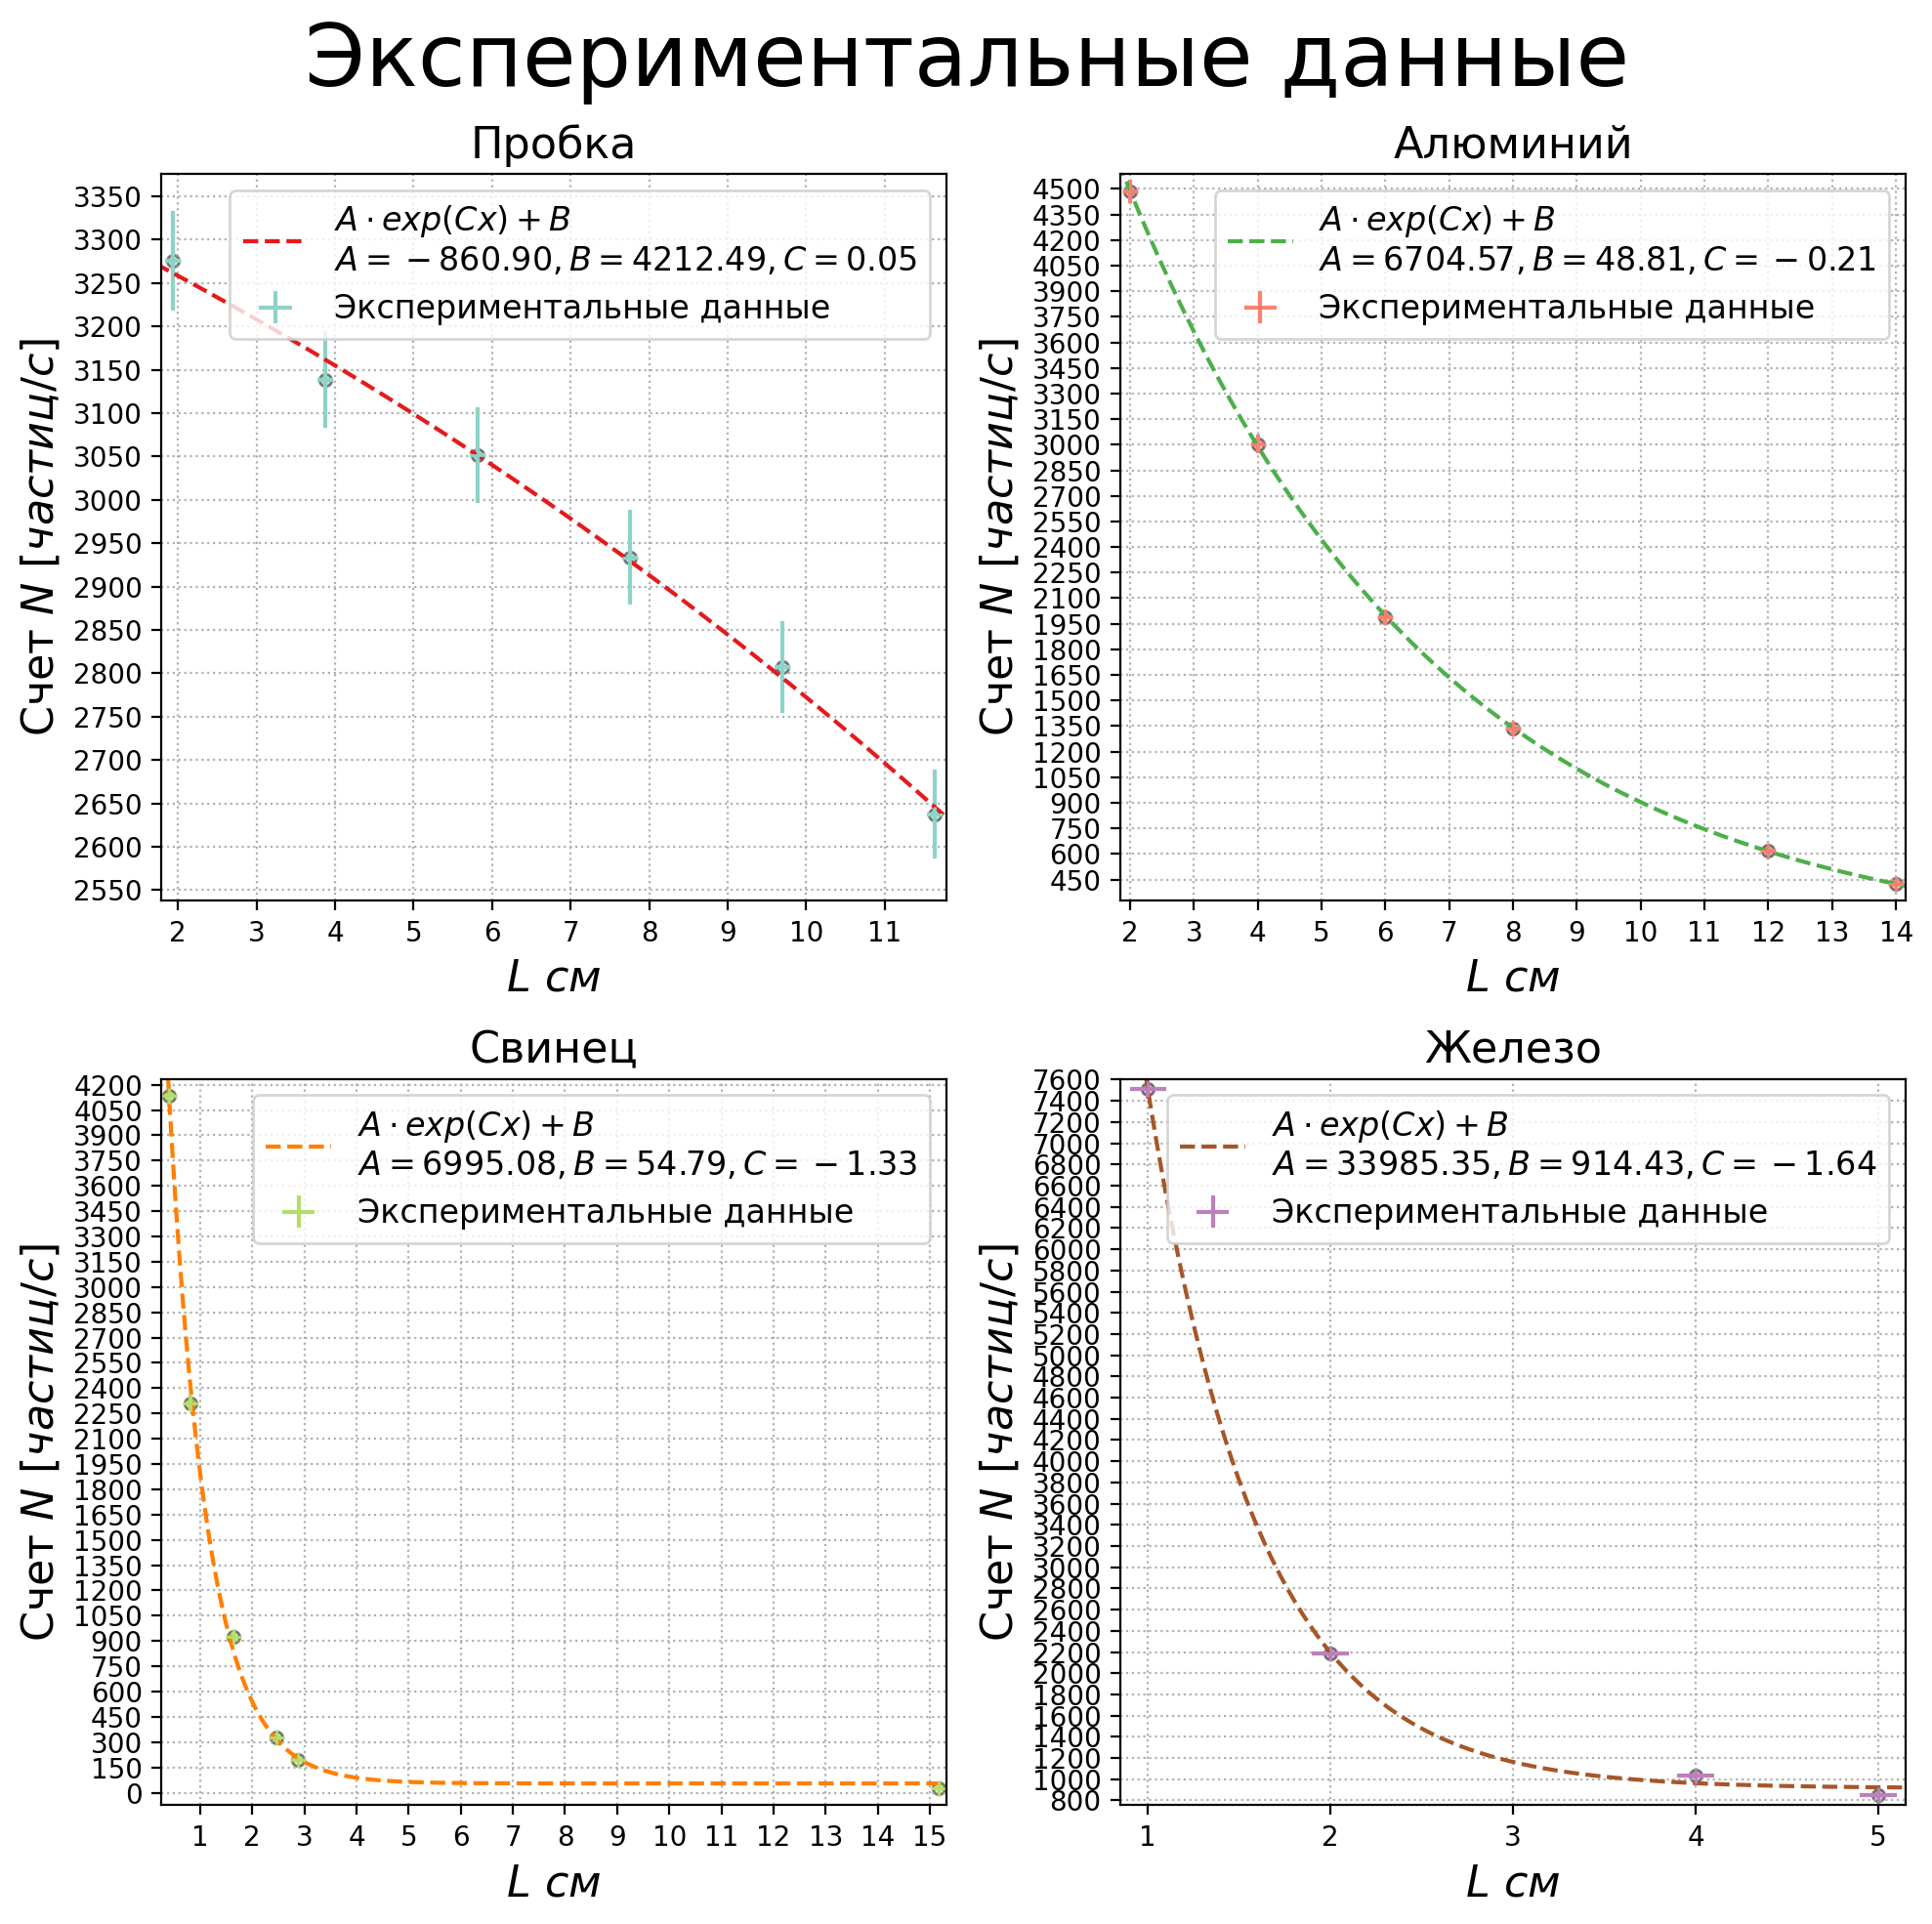

In [86]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10), dpi = 200)
color_values = np.arange(0, 2, 0.25)
step_y_values = [50, 150, 150, 200]
p0_values = [
    [200, -2, 0.5],
    [4000, 5, -3],
    [4000, 10, -20],
    [4000, 5, -3],
]
for plotable, color_interp, color_dots, name, table_name, step_y, p0 in zip(ax.ravel(), 
                                                                cm.Set1(color_values), 
                                                                cm.Set3(color_values), 
                                                                names, 
                                                                tables,
                                                                step_y_values,
                                                                p0_values):
    plotable.set_title(name, fontsize = 16)
    data = pd.read_csv(table_name)
    material_l = data['layers'] * layer_length[name]
    count = data['N'] / (data['t'] * 60)
    count_error = np.sqrt(count)
    
    param, _ = opt.curve_fit(interp_func, material_l, count, p0 = p0, maxfev = 10000)
    x_line = np.linspace(0, 20, 1000)
    xerr = [0.1 for _ in data['layers']]
    plotable.errorbar(material_l, 
                      count, 
                      color = color_dots, 
                      yerr = count_error, 
                      fmt = '+',
                      xerr = xerr,
                      label = 'Экспериментальные данные')
    plotable.plot(x_line, 
                  interp_func(x_line, *param), 
                  color = color_interp, 
                  linestyle = '--',
                  label = r'$A \cdot exp(C x) + B$' + f'\n$A = {param[1]:.2f}, B = {param[0]:.2f}, C = {param[2]:.2f}$')
    plotable.scatter(material_l, count, color = color_dots, alpha = 0.5, s = 20, edgecolor = 'k')
    plotable.grid(ls = ':')
    plotable.legend(fontsize = 12, loc = 'upper right')
    plotable.set_xticks(np.arange(0, 50, 1))
    plotable.set_xlim(np.min(material_l) - 0.15, np.max(material_l) + 0.15)
    plotable.set_yticks(np.arange(0, 20000, step_y))
    plotable.set_ylim(np.min(count) - 100, np.max(count) + 100)
    plotable.set_ylabel("Счет $N \ [частиц / c]$", fontsize = 16)
    plotable.set_xlabel('$L \ см$', fontsize = 16)

fig.suptitle("Экспериментальные данные", fontsize = 32)
fig.tight_layout()

### Линеаризация полученных зависимостей

In [88]:
N0 = 820565 / 60
N0_error = np.sqrt(N0)

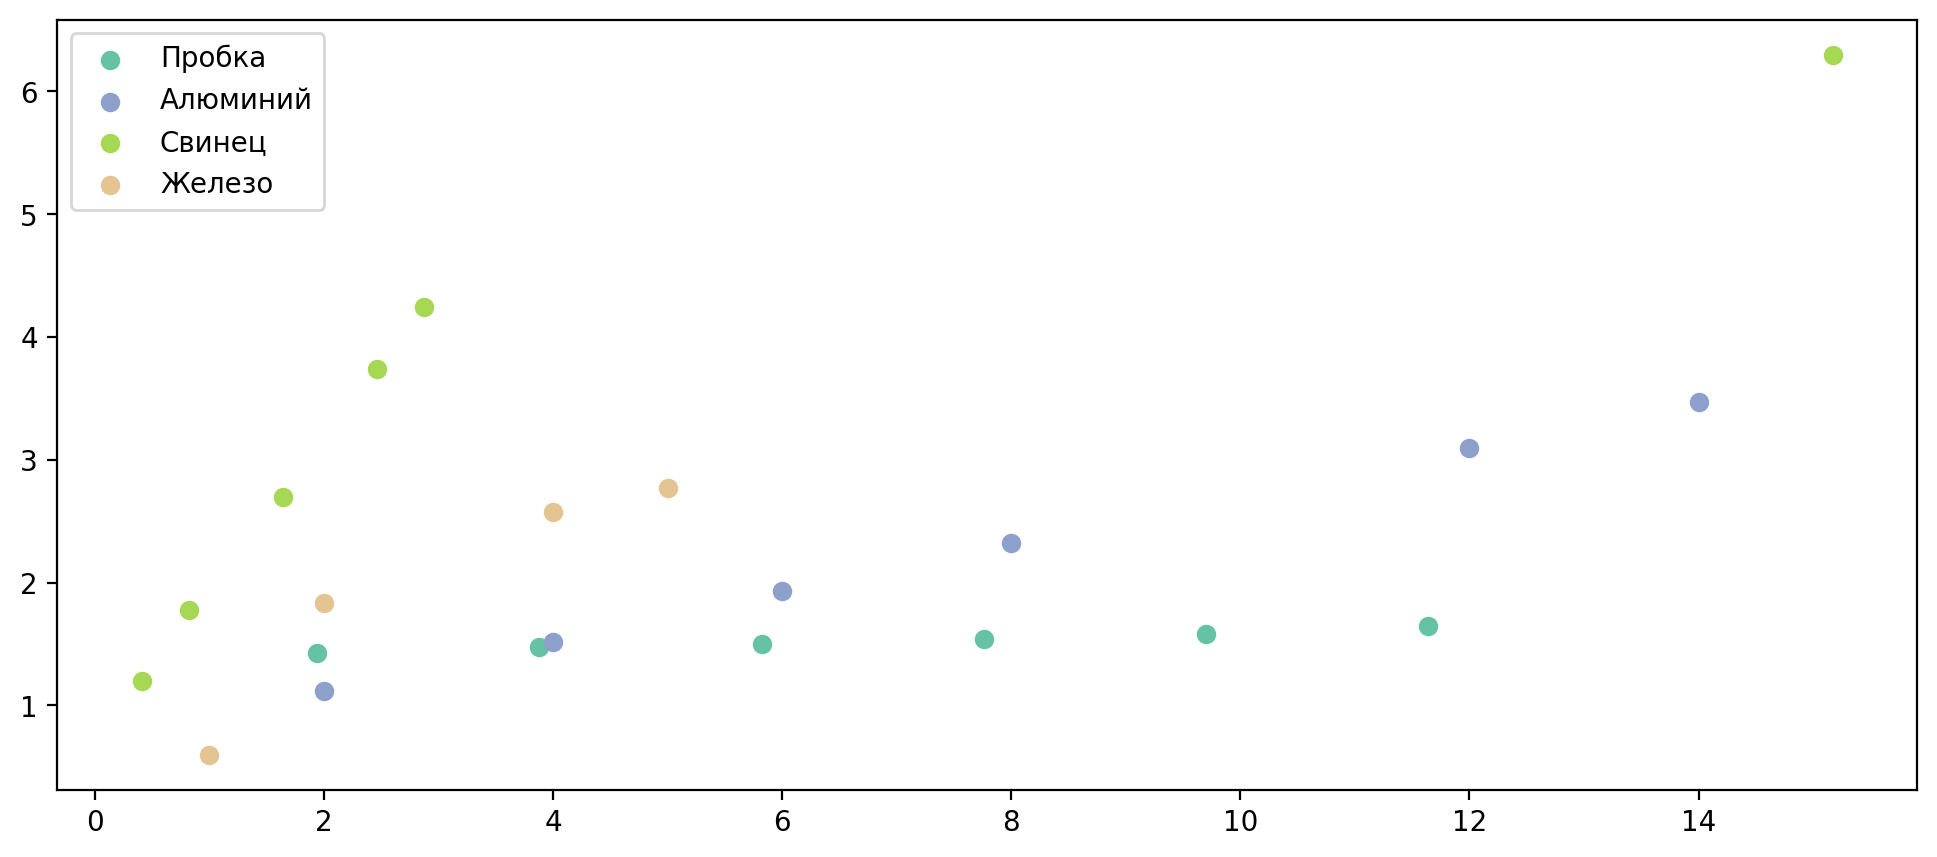

In [90]:
plt.figure(figsize = (12, 5), dpi = 200)
for color, name, table_name in zip(cm.Set2(color_values), 
                                   names, 
                                   tables):
    plotable.set_title(name, fontsize = 16)
    data = pd.read_csv(table_name)
    material_l = data['layers'] * layer_length[name]
    count = data['N'] / (data['t'] * 60)
    count_error = np.sqrt(count)
    lnN0N = np.log(N0 / count)
    plt.scatter(material_l, lnN0N, color = color, label = name)

plt.legend()